In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0, './Onedrive/Project-T2/PointNetJJ')
from spheres_JJ import sphere_generator
from spheres_JJ import ellipsoid_generator

from rotation import rotate_point_cloud
from rotation import LOP

   
nclouds = 5000
npoints = 100
s = 0.2

# The point clouds
spheres = torch.from_numpy(sphere_generator(0.0, nclouds, npoints))
trainset = spheres

# Labels
labels = torch.tensor(LOP(trainset, s)).view(-1,1).type(torch.FloatTensor)

dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                          shuffle=True, num_workers=2)

#####################################################
# Testing

ncloudstest = 1000
npointstest = 100

# The point clouds
spherestest = torch.from_numpy(sphere_generator(0.0, ncloudstest, npointstest))
testset = spherestest
test = testset

# Labels
testlabels = torch.tensor(LOP(testset, s)).view(-1,1).type(torch.FloatTensor)

labels_test = testlabels

testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2)

#############################################################3



In [2]:
class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(k)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        if self.training:
            x = F.relu(self.bn6(self.dropout(x) * 0.7))
            #x = self.bn6(self.dropout(x) * 0.7)
        else:
            x = F.relu(self.bn6(x))
            #x = self.bn6(x)))
        return x#F.log_softmax(x, dim=1)

In [3]:
net = PointNetCls(k=1)


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nepochs = 100
for epoch in range(nepochs):  # loop over the dataset multiple times
    epoch_train_acc = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(rotate_point_cloud(inputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 22.099
[2,   100] loss: 19.544
[3,   100] loss: 18.755
[4,   100] loss: 16.911
[5,   100] loss: 16.734
[6,   100] loss: 15.895
[7,   100] loss: 15.166
[8,   100] loss: 14.817
[9,   100] loss: 14.120
[10,   100] loss: 13.648
[11,   100] loss: 13.248
[12,   100] loss: 12.669
[13,   100] loss: 12.375
[14,   100] loss: 12.548
[15,   100] loss: 11.930
[16,   100] loss: 11.564
[17,   100] loss: 11.571
[18,   100] loss: 12.148
[19,   100] loss: 11.086
[20,   100] loss: 11.318
[21,   100] loss: 11.023
[22,   100] loss: 10.743
[23,   100] loss: 10.587
[24,   100] loss: 10.840
[25,   100] loss: 11.202
[26,   100] loss: 10.023
[27,   100] loss: 11.094
[28,   100] loss: 10.349
[29,   100] loss: 10.311
[30,   100] loss: 10.125
[31,   100] loss: 10.403
[32,   100] loss: 10.217
[33,   100] loss: 10.283
[34,   100] loss: 10.142
[35,   100] loss: 10.391
[36,   100] loss: 9.927
[37,   100] loss: 10.068
[38,   100] loss: 9.783
[39,   100] loss: 9.278
[40,   100] loss: 10.279
[41,   100] 

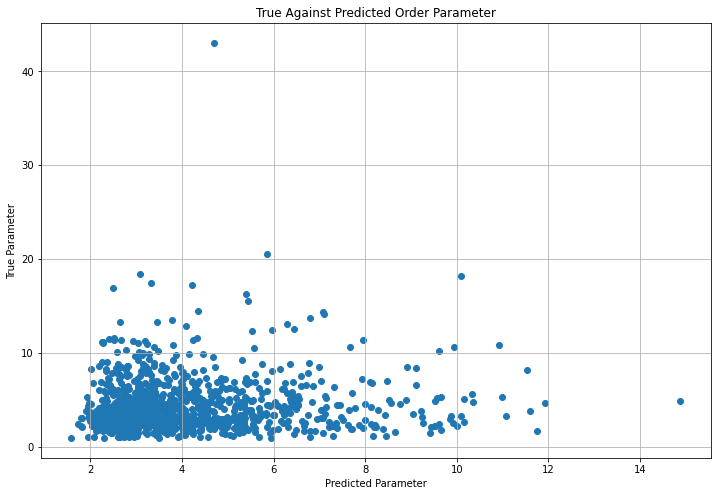

In [6]:
net.eval()
outputs = net(test)
x = outputs.detach().numpy()
y = labels_test

# plot the data
plt.figure(figsize=(12,8))
plt.scatter(x,y)
#plt.plot(np.linspace(0, 1, 10), np.power(np.linspace(0, 1, 10), 1), color = 'r', label = 'y = x')
plt.grid()
plt.title("True Against Predicted Order Parameter")
plt.ylabel("True Parameter")
plt.xlabel("Predicted Parameter")
plt.show()